In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
import torchvision.models as models
from torch.utils.data import DataLoader, TensorDataset,Dataset
import os
import copy

import timm

In [82]:
# Some user edits

# Model settings
sequence_len  = 12 # length of sequence for RNN in years
batch_size    = 4      # Batch size
percent_train = .8 # Percentage to train
netname       = 'resnet50' # Name of feature extractor 
cnn_out       = 3          # Number of features extracted by CNN (and input into RNN)
rnn_layers    = 1       # Number of RNN layers
outsize       = 1       # Final output size
outactivation = torch.tanh 
loss_fn       = nn.MSELoss()          # Loss Function
opt           = ['Adadelta',.01,0]    # Name optimizer
max_epochs    = 1
verbose       = True
checkgpu      = False
early_stop    = 1

# Data settings
ens           = 40 # Number of ensemble members to use
lead          = 1 # lead/lag between data and label
tstep         = 86 # number of timesteps


In [88]:
# Functions
def transfer_model(modelname,outsize):
    """
    Loads in pretrained model [modelname] for feature extraction
    All weights are frozen except the last layer, which is replaced with 
    a fully-connected layer with output size [outsize].
    
    Inputs
    ------
        1) modelname [STR] - Name of model in timm module
        2) outsize [INT] - Output size for fine tuning
    
    
    """
    
    if modelname == 'resnet50': # Load from torchvision
        #model = models.resnet50(pretrained=True) # read in resnet model
        model = timm.create_model(modelname)
        # Freeze all layers except the last
        for param in model.parameters():
            param.requires_grad = False
        model.fc = nn.Linear(model.fc.in_features, outsize)                    # freeze all layers except the last one
    else: # Load from timm
        model = timm.create_model(modelname)
        # Freeze all layers except the last
        for param in model.parameters():
            param.requires_grad = False
        model.classifier=nn.Linear(model.classifier.in_features,outsize)
    return model


class Combine(nn.Module):
    def __init__(self,feature_extractor,rnn,classifier,activation):
        super(Combine, self).__init__()
        self.cnn    = feature_extractor # Pretrained CNN (last layer unfrozen)
        self.rnn    = rnn # RNN unit (LSTM or GRU)
        self.linear = classifier # Classifier Layer
        self.activation = activation
    
    def forward(self, x):
        batch_size, timesteps, C, H, W = x.size()
        c_in = x.view(batch_size * timesteps, C, H, W)
        c_out = self.cnn(c_in)
        r_in = c_out.view(batch_size, timesteps, -1)
        r_out, (h_n, h_c) = self.rnn(r_in)
        r_out2 = self.linear(r_out[:, :, :])
        
        return self.activation(r_out2)

In [77]:
%%time
# Load in the data 
# Data : [channel, ensemble, time, lat, lon]
# Label: [ensemble, time]

# Load the data for whole North Atlantic
data   = np.load('../../CESM_data/CESM_data_sst_sss_psl_deseason_normalized_resized.npy')
target = np.load('../../CESM_data/CESM_label_amv_index.npy')
data   = data[:,0:ens,:,:,:]
target = target[0:ens,:]





CPU times: user 1.34 ms, sys: 847 ms, total: 849 ms
Wall time: 848 ms


In [78]:
# Set up data loader

#indata = data[:,:batch_size,:,:,:]
#inlabel = target[:batch_size,:]
#C,B,T,H,W = indata.shape
#inlabel.shape,indata.shape

# ----------------------
# Apply lead/lag to data
# ----------------------

y = target[:ens,lead:]#.reshape(ens*(tstep-lead),1)
X = (data[:,:,:tstep-lead,:,:].transpose(1,2,0,3,4)) # [Transpose to ens x time x channel x lat x lon]
#X = (data[:,:,:tstep-lead,:,:]).transpose(#.reshape(3,ens*(tstep-lead),224,224).transpose(1,0,2,3)
        
# ---------------------------------
# Split into training and test sets
# ---------------------------------
X_train = torch.from_numpy( X[0:int(np.floor(percent_train*ens)),:,:,:,:].astype(np.float32) )
X_val = torch.from_numpy( X[int(np.floor(percent_train*ens)):,:,:,:,:].astype(np.float32) )

y_train = torch.from_numpy(  y[0:int(np.floor(percent_train*ens)),:,None].astype(np.float32)  )
y_val = torch.from_numpy( y[int(np.floor(percent_train*ens)):,:,None].astype(np.float32)  )

# Put into pytorch DataLoader
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size)
val_loader   = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size)


## Test things out

In [79]:
# Load sample data
testdata = []
for data in train_loader:
    testdata.append(data)

test = testdata[0][0]
tlabel = testdata[0][1]
len(testdata),test.size(),tlabel.shape

(8, torch.Size([4, 85, 3, 224, 224]), torch.Size([4, 85, 1]))

In [80]:


# Get the model
model = transfer_model(netname,cnn_out)

# Define the LSTM or RNN unit
rnn = nn.LSTM(
        input_size=cnn_out,
        hidden_size=sequence_len,
        num_layers=rnn_layers,
        batch_first=True # Input is [batch,seq,feature]
        )

# Classifier
classifier = nn.Linear(sequence_len,outsize)

In [81]:
%%time
# Combine batchsize and timesteps and put into feature extractor
x = test
bsize, timesteps, C, H, W = x.size()
c_in  = x.view(bsize * timesteps, C, H, W)
c_out = model(c_in) # output is [bsize*timesteps,channels]
c_out.shape

CPU times: user 59.5 s, sys: 8.74 s, total: 1min 8s
Wall time: 1min 8s


torch.Size([340, 3])

In [28]:
%%time
r_in = c_out.view(bsize, timesteps, -1)
r_out, (h_n, h_c) = rnn(r_in)

#r_out2 = self.linear(r_out[:, -1, :])

r_out.shape

CPU times: user 6.89 ms, sys: 1.23 ms, total: 8.12 ms
Wall time: 6.8 ms


torch.Size([4, 86, 12])

In [29]:
r_out2 = classifier(r_out[:, :, :]) # Get last value and pass into the linear layer
prediction = torch.tanh(r_out2) # [ens x 1]


r_out2.shape,prediction.shape

(torch.Size([4, 86, 1]), torch.Size([4, 86, 1]))

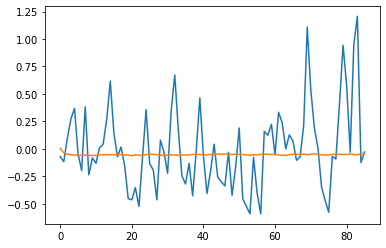

In [30]:
fig,ax = plt.subplots(1,1)
ax.plot(tlabel[0,:],label='label')
ax.plot(prediction[0,:,0].detach().numpy(),label='prediction')

In [75]:
prediction

tensor([[[0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [

In [89]:
# Test out the combine

seqmodel = Combine(model,rnn,classifier,outactivation)
#seqmodel

# Get list of params to update
params_to_update = []
for name,param in seqmodel.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("Params to learn:")
        print("\t",name)

Params to learn:
	 cnn.fc.weight
Params to learn:
	 cnn.fc.bias
Params to learn:
	 rnn.weight_ih_l0
Params to learn:
	 rnn.weight_hh_l0
Params to learn:
	 rnn.bias_ih_l0
Params to learn:
	 rnn.bias_hh_l0
Params to learn:
	 linear.weight
Params to learn:
	 linear.bias


In [85]:
def train_ResNet(model,loss_fn,optimizer,trainloader,testloader,max_epochs,early_stop=False,verbose=True):
    """
    inputs:
        model       - Resnet model
        loss_fn     - (torch.nn) loss function
        opt         - tuple of [optimizer_name, learning_rate, weight_decay] for updating the weights
                      currently supports "Adadelta" and "SGD" optimizers
        trainloader - (torch.utils.data.DataLoader) for training datasetmo
        testloader  - (torch.utils.data.DataLoader) for testing dataset
        max_epochs  - number of training epochs
        early_stop  - BOOL or INT, Stop training after N epochs of increasing validation error
                     (set to False to stop at max epoch, or INT for number of epochs)
        verbose     - set to True to display training messages
    
    output:
    
    dependencies:
        from torch import nn,optim
        
    """
    
    # #model =   timm.create_model('tf_efficientnet_l2_ns') # read in resnet model
    # model = timm.create_model("tf_efficientnet_b7_ns")
    # for param in model.parameters():
    #     print(param)
    #     print(param.requires_grad)
    #     param.requires_grad = False
    
    # #model.classifier = nn.Linear(5504, 1) # freeze all layers except the last one l2-noisy student
    # model.classifier=nn.Linear(model.classifier.in_features,1)
    
    bestloss = np.infty
    
    # Check if there is GPU
    if checkgpu:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    else:
        device = torch.device('cpu')
    model = model.to(device)
    
    
    # Get list of params to update
    params_to_update = []
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            if verbose:
                print("Params to learn:")
                print("\t",name)
    
    
    # Set optimizer
    if optimizer[0] == "Adadelta":
        opt = optim.Adadelta(params_to_update,lr=optimizer[1],weight_decay=optimizer[2])
    elif optimizer[0] == "SGD":
        opt = optim.SGD(params_to_update,lr=optimizer[1],weight_decay=optimizer[2])
    elif optimizer[0] == 'Adam':
        opt = optim.Adam(params_to_update,lr=optimizer[1],weight_decay=optimizer[2])
    
    # Set early stopping threshold and counter
    if early_stop is False:
        i_thres = max_epochs
    else:
        i_thres = early_stop
    i_incr    = 0 # Number of epochs for which the validation loss increases
    prev_loss = 0 # Variable to store previous loss
    
    # Main Loop
    train_loss,test_loss = [],[]   # Preallocate tuples to store loss
    for epoch in tqdm(range(max_epochs)): # loop by epoch
    #for epoch in range(max_epochs):
        for mode,data_loader in [('train',trainloader),('eval',testloader)]: # train/test for each epoch
    
            if mode == 'train':  # Training, update weights
                model.train()
            elif mode == 'eval': # Testing, freeze weights
                model.eval()
               
            runningloss = 0
            for i,data in enumerate(data_loader):
                
                # Get mini batch
                batch_x, batch_y = data
                batch_x = batch_x.to(device)
                batch_y = batch_y.to(device)
                
                # Set gradients to zero
                opt.zero_grad()
                
                # Forward pass
                pred_y = model(batch_x)
                
                # Calculate losslay
                loss = loss_fn(pred_y,batch_y)
                
                # Update weights
                if mode == 'train':
                    loss.backward() # Backward pass to calculate gradients w.r.t. loss
                    opt.step()      # Update weights using optimizer
                
                runningloss += float(loss.item())

            if verbose: # Print progress message
                print('{} Set: Epoch {:02d}. loss: {:3f}'.format(mode, epoch+1, \
                                                runningloss/len(data_loader)))
            
            # Save model if this is the best loss
            if (runningloss/len(data_loader) < bestloss) and (mode == 'eval'):
                bestloss = runningloss/len(data_loader)
                bestmodel = copy.deepcopy(model)
                #best_model_wts = copy.deepcopy(model.state_dict())
                if verbose:
                    print("Best Loss of %f at epoch %i"% (bestloss,epoch+1))
                
            # Save running loss values for the epoch
            if mode == 'train':
                train_loss.append(runningloss/len(data_loader))
            else:
                test_loss.append(runningloss/len(data_loader))
                
                # Evaluate if early stopping is needed
                if epoch == 0: # Save previous loss
                    lossprev = runningloss/len(data_loader)
                else: # Add to counter if validation loss increases
                    if runningloss/len(data_loader) > lossprev:
                        if verbose:
                            print("Validation loss has increased at epoch %i"%(epoch+1))
                        i_incr += 1
                        lossprev = runningloss/len(data_loader)
                        
                if (epoch != 0) and (i_incr >= i_thres):
                    print("\tEarly stop at epoch %i "% (epoch+1))
                    return bestmodel,train_loss,test_loss  
            
            # Clear some memory
            #print("Before clearing in epoch %i mode %s, memory is %i"%(epoch,mode,torch.cuda.memory_allocated(device)))
            del batch_x
            del batch_y
            torch.cuda.empty_cache() 
            #print("After clearing in epoch %i mode %s, memory is %i"%(epoch,mode,torch.cuda.memory_allocated(device)))
                
    #bestmodel.load_state_dict(best_model_wts)         
    return bestmodel,train_loss,test_loss    

In [91]:
%%time
smodel,trainloss,testloss = train_ResNet(seqmodel,loss_fn,opt,train_loader,val_loader,max_epochs,early_stop=early_stop,verbose=verbose)
        

  0%|          | 0/1 [00:00<?, ?it/s]

Params to learn:
	 cnn.fc.weight
Params to learn:
	 cnn.fc.bias
Params to learn:
	 rnn.weight_ih_l0
Params to learn:
	 rnn.weight_hh_l0
Params to learn:
	 rnn.bias_ih_l0
Params to learn:
	 rnn.bias_hh_l0
Params to learn:
	 linear.weight
Params to learn:
	 linear.bias
train Set: Epoch 01. loss: 0.154774


100%|██████████| 1/1 [10:18<00:00, 618.51s/it]

eval Set: Epoch 01. loss: 0.166188
Best Loss of 0.166188 at epoch 1
CPU times: user 9min 25s, sys: 1min 16s, total: 10min 42s
Wall time: 10min 18s


In [92]:
%%time
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
X_val = X_val.to(device)

y_pred_val = np.asarray([[],[],[],[]]).T
y_valdt    = np.asarray([[],[],[],[]]).T
for i,vdata in enumerate(val_loader):
    # Get mini batch
    batch_x, batch_y = vdata
    batch_x = batch_x.to(device)
    batch_y = batch_y.to(device)

    
    # Make prediction and concatenate
    batch_pred = smodel(batch_x)
    
    print(batch_pred.detach().cpu().numpy().shape)
    print(batch_y.detach().cpu().numpy().shape)
    
    if i == 0:
        y_pred_val=batch_pred.detach().cpu().numpy().squeeze()
        y_valdt = batch_y.detach().cpu().numpy().squeeze()
    else:
        y_pred_val = np.concatenate([y_pred_val,batch_pred.detach().cpu().numpy().squeeze()])
        y_valdt = np.concatenate([y_valdt,batch_y.detach().cpu().numpy().squeeze()])

(4, 85, 1)
(4, 85, 1)
(4, 85, 1)
(4, 85, 1)


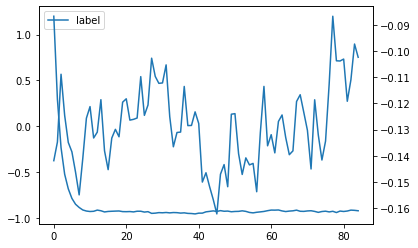

In [98]:
i = 4
fig,ax = plt.subplots(1,1)

ax.plot(y_valdt[i,:],label='label')
ax2 = ax.twinx()
ax2.plot(y_pred_val[i,:],label='prediction')
ax.legend()

In [66]:
y_valdt.shape

(8, 86)

In [94]:
# Calculate correlation between each timeseries
testcorr = []
for i in range(y_pred_val.shape[0]):
    testcorr.append(np.corrcoef( y_pred_val.T[i,:], y_valdt.T[i,:])[0,1])

In [95]:
testcorr


[-0.3469255158422895,
 0.09424422387508474,
 -0.3586129755442375,
 -0.39330573573453675,
 0.2567454933792695,
 0.2352215809744237,
 -0.0765182133032967,
 -0.24265041572525015]

Text(0, 0.5, 'Pred')

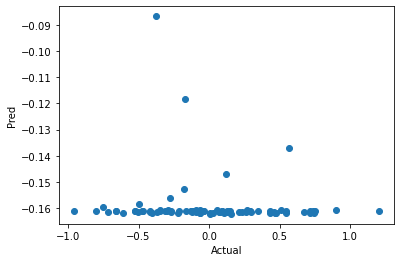

In [97]:
i = 4
fig,ax = plt.subplots(1,1)

ax.scatter(y_valdt[i,:],y_pred_val[i,:])
ax.set_xlabel("Actual")
ax.set_ylabel("Pred")
